In [1]:
#necessary imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import os
import xgboost as xgb

from math import ceil,sqrt as root
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error,mean_squared_log_error,r2_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
#import datasets
train_df = pd.read_csv('house-prices-advanced-regression-techniques/train.csv')
test_df = pd.read_csv('house-prices-advanced-regression-techniques/test.csv')
sub_df = pd.read_csv('house-prices-advanced-regression-techniques/sample_submission.csv')

In [3]:
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Exploratory Data Analysis

In [4]:
print('Train: ',train_df.shape[0],' sales, and', train_df.shape[1],' features')
print('Test: ',test_df.shape[0],' sales, and ',test_df.shape[1],' features')

Train:  1460  sales, and 81  features
Test:  1459  sales, and  80  features


In [5]:
sub_df.head()

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [7]:
train_df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [8]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

In [9]:
sum(test_df['Id']=='NAN')

0

In [10]:
sum(train_df['Id']=='NAN')

0

In [11]:
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [12]:
test_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


## Data Preprocessing

### Check and Remove outliers

In [13]:
corr = train_df.corr()

In [14]:
corr.sort_values('SalePrice')

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
KitchenAbvGr,0.002951,0.281721,-0.006069,-0.017784,-0.183882,-0.087001,-0.174800,-0.149598,-0.037610,-0.081007,...,-0.090130,-0.070091,0.037312,-0.024600,-0.051613,-0.014525,0.062341,0.026589,0.031687,-0.135907
EnclosedPorch,0.002889,-0.012037,0.010700,-0.018340,-0.113937,0.070356,-0.387268,-0.193919,-0.110204,-0.102303,...,-0.125989,-0.093079,1.000000,-0.037305,-0.082864,0.054203,0.018361,-0.028887,-0.009916,-0.128578
MSSubClass,0.011156,1.000000,-0.386347,-0.139781,0.032628,-0.059316,0.027850,0.040581,0.022936,-0.069836,...,-0.012579,-0.006100,-0.012037,-0.043825,-0.026030,0.008283,-0.007683,-0.013585,-0.021407,-0.084284
OverallCond,0.012609,-0.059316,-0.059213,-0.005636,-0.091932,1.000000,-0.375983,0.073741,-0.128101,-0.046231,...,-0.003334,-0.032589,0.070356,0.025504,0.054811,-0.001985,0.068777,-0.003511,0.043950,-0.077856
YrSold,0.000712,-0.021407,0.007450,-0.014261,-0.027347,0.043950,-0.013618,0.035743,-0.008201,0.014359,...,0.022270,-0.057619,-0.009916,0.018645,0.010694,-0.059689,0.004906,-0.145721,1.000000,-0.028923
LowQualFinSF,-0.044230,0.046474,0.038469,0.004779,-0.030429,0.025494,-0.183784,-0.062419,-0.069071,-0.064503,...,-0.025444,0.018251,0.061081,-0.004296,0.026799,0.062157,-0.003793,-0.022174,-0.028921,-0.025606
Id,1.000000,0.011156,-0.010601,-0.033226,-0.028365,0.012609,-0.012713,-0.021998,-0.050298,-0.005024,...,-0.029643,-0.000477,0.002889,-0.046635,0.001330,0.057044,-0.006242,0.021172,0.000712,-0.021917
MiscVal,-0.006242,-0.007683,0.003368,0.038068,-0.031406,0.068777,-0.034383,-0.010286,-0.029815,0.003571,...,-0.009551,-0.018584,0.018361,0.000354,0.031946,0.029669,1.000000,-0.006495,0.004906,-0.021190
BsmtHalfBath,-0.020155,-0.002333,-0.007234,0.048046,-0.040150,0.117821,-0.038162,-0.012337,0.026673,0.067418,...,0.040161,-0.025324,-0.008555,0.035114,0.032121,0.020025,-0.007367,0.032873,-0.046524,-0.016844
BsmtFinSF2,-0.005968,-0.065649,0.049900,0.111170,-0.059119,0.040229,-0.049107,-0.067759,-0.072319,-0.050117,...,0.067898,0.003093,0.036543,-0.029993,0.088871,0.041709,0.004940,-0.015211,0.031706,-0.011378


In [16]:
train_df.corr()['SalePrice'].sort_values()

KitchenAbvGr    -0.135907
EnclosedPorch   -0.128578
MSSubClass      -0.084284
OverallCond     -0.077856
YrSold          -0.028923
LowQualFinSF    -0.025606
Id              -0.021917
MiscVal         -0.021190
BsmtHalfBath    -0.016844
BsmtFinSF2      -0.011378
3SsnPorch        0.044584
MoSold           0.046432
PoolArea         0.092404
ScreenPorch      0.111447
BedroomAbvGr     0.168213
BsmtUnfSF        0.214479
BsmtFullBath     0.227122
LotArea          0.263843
HalfBath         0.284108
OpenPorchSF      0.315856
2ndFlrSF         0.319334
WoodDeckSF       0.324413
LotFrontage      0.351799
BsmtFinSF1       0.386420
Fireplaces       0.466929
MasVnrArea       0.477493
GarageYrBlt      0.486362
YearRemodAdd     0.507101
YearBuilt        0.522897
TotRmsAbvGrd     0.533723
FullBath         0.560664
1stFlrSF         0.605852
TotalBsmtSF      0.613581
GarageArea       0.623431
GarageCars       0.640409
GrLivArea        0.708624
OverallQual      0.790982
SalePrice        1.000000
Name: SalePr

from the output above, it is observed that some of the features have a high correlation with the target `SalePrice`. Now, we visualize some of them such as `OverallQual`, `GrLivarea`,`GarageCars`,`GarageArea`

Visualizing the `OverallQual` feature using `scattered plot`

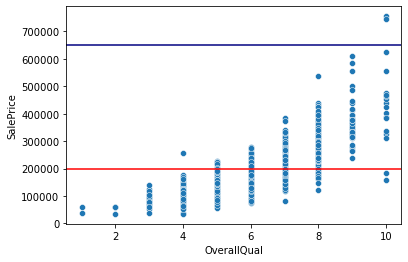

In [17]:
sns.scatterplot(x=train_df['OverallQual'],y=train_df['SalePrice'])
plt.axhline(y=[200000],color='red')
plt.axhline(y=[650000],color='navy');

In [18]:
train_df[(train_df['OverallQual']>8) & (train_df['SalePrice']<200000)][['SalePrice', 'OverallQual']]

,SalePrice,OverallQual
523,184750,10
1298,160000,10


Visualizing the `GrLiveArea` feature using `scatterplot`

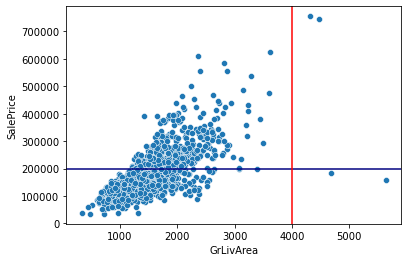

In [19]:
sns.scatterplot(x=train_df['GrLivArea'],y=train_df['SalePrice'])
plt.axhline(y=[200000], color='navy')
plt.axvline(x=[4000], color='red');

In [20]:
train_df[(train_df['GrLivArea']>4000) & (train_df['SalePrice']>200000)][['SalePrice','GrLivArea']]

,SalePrice,GrLivArea
691,755000,4316
1182,745000,4476


Visualizing the `GarageCars` feature using `scatterplot`

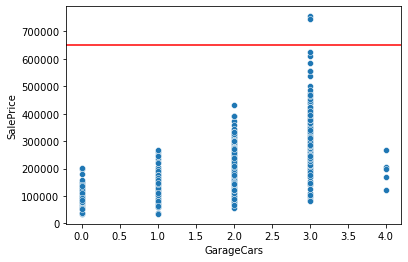

In [21]:
sns.scatterplot(x=train_df['GarageCars'],y=train_df['SalePrice'])
plt.axhline(y=[650000], color='red');

In [22]:
train_df[(train_df['SalePrice']>650000)][['SalePrice','GarageCars']]

,SalePrice,GarageCars
691,755000,3
1182,745000,3


Visualizing the `GarageArea` feature using `scatterplot`

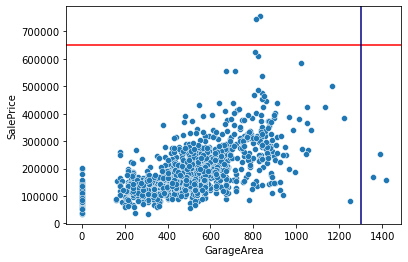

In [23]:
sns.scatterplot(x=train_df['GarageArea'],y=train_df['SalePrice'])
plt.axhline(y=[650000], color='red')
plt.axvline(x=[1300], color='navy')

In [24]:
train_df[(train_df['SalePrice']>650000)][['SalePrice','GarageArea']]

,SalePrice,GarageArea
691,755000,832
1182,745000,813


In [25]:
train_df[(train_df['GarageArea']>1300) & (train_df['SalePrice']<300000)][['SalePrice','GarageArea']]

,SalePrice,GarageArea
581,253293,1390
1190,168000,1356
1298,160000,1418


Removing the outliers

In [26]:
index_drop = train_df[train_df["SalePrice"]>650000].index
train_df.drop(index_drop, axis=0, inplace=True)
index_drop1 = train_df[(train_df['OverallQual']>8) & (train_df['SalePrice']<200000)].index
train_df.drop(index_drop1, axis=0, inplace=True)
index_drop2 = train_df[(train_df['GarageArea']>1300) & (train_df['SalePrice']<300000)].index
train_df.drop(index_drop2, axis=0, inplace=True)
# index_drop3 = train_df[(train_df['GrLivArea']>4000) & (train_df['SalePrice']<200000)].index
# train_df.drop(index_drop3, axis=0, inplace=True)

In [27]:
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [28]:
train_df.corr()['SalePrice'].sort_values()

KitchenAbvGr    -0.138782
EnclosedPorch   -0.129630
MSSubClass      -0.087597
OverallCond     -0.080104
BsmtHalfBath    -0.036675
Id              -0.027127
LowQualFinSF    -0.025293
YrSold          -0.024362
MiscVal         -0.021056
BsmtFinSF2      -0.008745
PoolArea         0.032861
3SsnPorch        0.047494
MoSold           0.056311
ScreenPorch      0.118516
BedroomAbvGr     0.160506
BsmtUnfSF        0.219372
BsmtFullBath     0.236586
LotArea          0.270515
HalfBath         0.282329
2ndFlrSF         0.297963
WoodDeckSF       0.324344
OpenPorchSF      0.330058
LotFrontage      0.356182
BsmtFinSF1       0.397425
Fireplaces       0.466701
MasVnrArea       0.478514
GarageYrBlt      0.498833
YearRemodAdd     0.521062
YearBuilt        0.534909
TotRmsAbvGrd     0.537236
FullBath         0.558917
1stFlrSF         0.625579
GarageArea       0.642832
TotalBsmtSF      0.646606
GarageCars       0.651335
GrLivArea        0.720367
OverallQual      0.801212
SalePrice        1.000000
Name: SalePr

The result above shows that after removing the outliers frm the features, their correlation with the target `SalePrice` increased.

### Feature Engineering

In [29]:
corr = train_df.corr()
corr

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
Id,1.000000,0.008539,-0.025236,-0.039751,-0.030900,0.014294,-0.013500,-0.022459,-0.053049,-0.019361,...,-0.033005,-0.001780,0.003534,-0.046502,0.001813,0.040919,-0.006096,0.024348,0.001471,-0.027127
MSSubClass,0.008539,1.000000,-0.408154,-0.147675,0.036733,-0.056780,0.029270,0.042364,0.023013,-0.079899,...,-0.019383,-0.004777,-0.011447,-0.043781,-0.025651,0.008077,-0.007556,-0.010523,-0.019549,-0.087597
LotFrontage,-0.025236,-0.408154,1.000000,0.387459,0.224923,-0.055186,0.112836,0.078721,0.161043,0.134836,...,0.077980,0.115521,0.017401,0.075735,0.048140,0.075267,0.005778,0.027434,0.009685,0.356182
LotArea,-0.039751,-0.147675,0.387459,1.000000,0.091131,-0.000579,0.006931,0.007492,0.080758,0.171534,...,0.163668,0.062789,-0.015527,0.021741,0.046161,0.034033,0.039410,0.009004,-0.012237,0.270515
OverallQual,-0.030900,0.036733,0.224923,0.091131,1.000000,-0.091885,0.571343,0.550460,0.399977,0.216416,...,0.237443,0.296952,-0.112615,0.031657,0.067811,0.018143,-0.031122,0.074686,-0.025867,0.801212
OverallCond,0.014294,-0.056780,-0.055186,-0.000579,-0.091885,1.000000,-0.376085,0.074757,-0.129544,-0.041358,...,-0.000649,-0.030132,0.069685,0.025284,0.054302,0.008008,0.068667,-0.004120,0.043525,-0.080104
YearBuilt,-0.013500,0.029270,0.112836,0.006931,0.571343,-0.376085,1.000000,0.591465,0.313479,0.249980,...,0.224711,0.183341,-0.386933,0.031806,-0.049568,-0.014345,-0.034158,0.013091,-0.013494,0.534909
YearRemodAdd,-0.022459,0.042364,0.078721,0.007492,0.550460,0.074757,0.591465,1.000000,0.175401,0.123286,...,0.206216,0.222073,-0.193299,0.045677,-0.038070,-0.009468,-0.010063,0.021753,0.035715,0.521062
MasVnrArea,-0.053049,0.023013,0.161043,0.080758,0.399977,-0.129544,0.313479,0.175401,1.000000,0.236485,...,0.150078,0.105750,-0.109164,0.020395,0.065597,-0.015975,-0.029619,0.003755,-0.005479,0.478514
BsmtFinSF1,-0.019361,-0.079899,0.134836,0.171534,0.216416,-0.041358,0.249980,0.123286,0.236485,1.000000,...,0.198579,0.073255,-0.103035,0.029972,0.070246,0.016428,0.005196,0.000082,0.019871,0.397425


<AxesSubplot:>

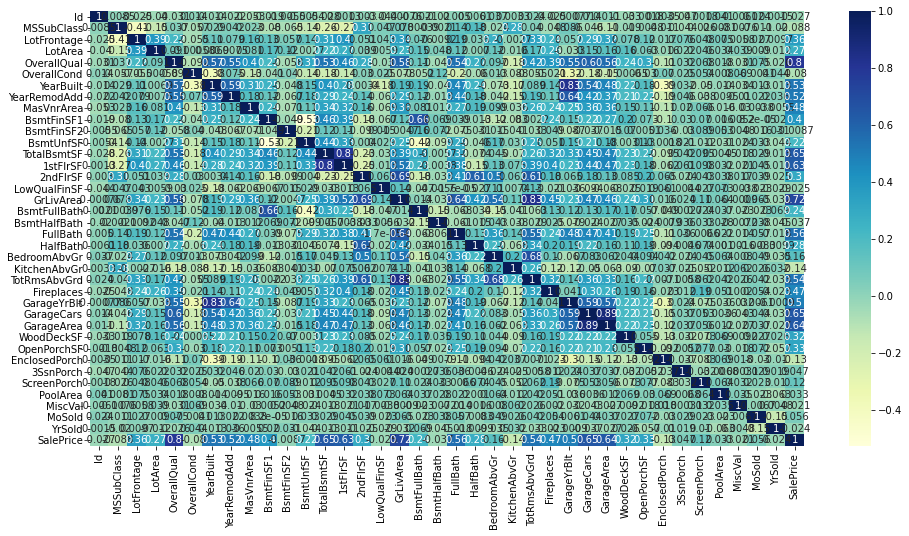

In [30]:
plt.figure(figsize=(16,8))
sns.heatmap(corr,
           cmap='YlGnBu',
           fmt='.2g',
           annot=True)

Dealing with Missing Values

In [31]:
train_df.isna().sum().sort_values()

Id                  0
TotalBsmtSF         0
Heating             0
SaleCondition       0
CentralAir          0
                 ... 
FireplaceQu       690
Fence            1174
Alley            1363
MiscFeature      1400
PoolQC           1449
Length: 81, dtype: int64

Check for missing numerical columns

In [32]:
df_temp = train_df.copy()

In [33]:
df_temp.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [34]:
df_temp.shape

(1454, 81)

In [35]:
df_temp.isna().sum().sort_values()

Id                  0
TotalBsmtSF         0
Heating             0
SaleCondition       0
CentralAir          0
                 ... 
FireplaceQu       690
Fence            1174
Alley            1363
MiscFeature      1400
PoolQC           1449
Length: 81, dtype: int64

In [36]:
#define a function to return the missing value percent
def missing_percent(df_temp):
    nan_percent = 100 * (df_temp.isnull().sum()/len(df_temp))
    nan_percent = nan_percent[nan_percent>0].sort_values()
    return nan_percent

In [37]:
nan_percent = missing_percent(df_temp)
nan_percent

Electrical       0.068776
MasVnrType       0.550206
MasVnrArea       0.550206
BsmtQual         2.544704
BsmtCond         2.544704
BsmtFinType1     2.544704
BsmtExposure     2.613480
BsmtFinType2     2.613480
GarageCond       5.570839
GarageQual       5.570839
GarageFinish     5.570839
GarageType       5.570839
GarageYrBlt      5.570839
LotFrontage     17.744154
FireplaceQu     47.455296
Fence           80.742779
Alley           93.741403
MiscFeature     96.286107
PoolQC          99.656121
dtype: float64

<AxesSubplot:>

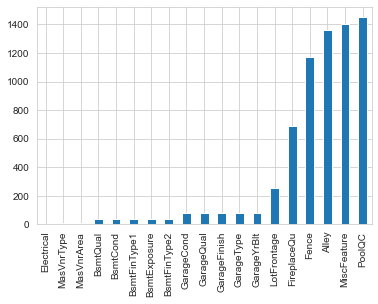

In [38]:
sns.set_style('whitegrid')
missing = df_temp.isnull().sum()
missing = missing[missing > 0].sort_values()
missing.plot.bar()

Filling the missing numerical and categorical columns

In [39]:
for label, content in df_temp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

LotFrontage
MasVnrArea
GarageYrBlt


In [40]:
df_temp_test = test_df.copy()

In [41]:
for label, content in df_temp_test.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

LotFrontage
MasVnrArea
BsmtFinSF1
BsmtFinSF2
BsmtUnfSF
TotalBsmtSF
BsmtFullBath
BsmtHalfBath
GarageYrBlt
GarageCars
GarageArea


In [42]:
# filling the numerical columns with the median and the categorical columns with `None`
train_num = train_df.select_dtypes(exclude='object')
train_obj = train_df.select_dtypes(include='object')

test_num = test_df.select_dtypes(exclude='object')
test_obj = train_df.select_dtypes(include='object')

In [43]:
train_obj = train_obj.fillna("None")
train_num = train_num.fillna(train_num.median())

test_obj = test_obj.fillna("None")
test_num = test_num.fillna(test_num.median())

Encoding the Categorical features

In [44]:
train_obj= pd.get_dummies(train_obj, drop_first=True)

test_obj= pd.get_dummies(test_obj, drop_first=True)

In [45]:
train_obj

,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,Alley_None,Alley_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0,0,1,0,1,1,0,0,0,1,...,0,0,0,0,1,0,0,0,1,0
1,0,0,1,0,1,1,0,0,0,1,...,0,0,0,0,1,0,0,0,1,0
2,0,0,1,0,1,1,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
3,0,0,1,0,1,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,1,0,1,1,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,0,0,1,0,1,1,0,0,0,1,...,0,0,0,0,1,0,0,0,1,0
1456,0,0,1,0,1,1,0,0,0,1,...,0,0,0,0,1,0,0,0,1,0
1457,0,0,1,0,1,1,0,0,0,1,...,0,0,0,0,1,0,0,0,1,0
1458,0,0,1,0,1,1,0,0,0,1,...,0,0,0,0,1,0,0,0,1,0


In [46]:
training_data= pd.concat([train_num, train_obj], axis=1)
training_data.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,0,0,0,1,0,0,0,1,0
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,0,0,0,0,1,0,0,0,1,0
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,0,0,0,1,0,0,0,1,0
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,0,0,0,1,0,0,0,0,0
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,0,0,0,0,1,0,0,0,1,0


In [47]:
training_data.shape

(1454, 261)

In [48]:
test_data = pd.concat([test_num, test_obj], axis=1)
test_data.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1461.0,20.0,80.0,11622.0,5.0,6.0,1961.0,1961.0,0.0,468.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,1462.0,20.0,81.0,14267.0,6.0,6.0,1958.0,1958.0,108.0,923.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,1463.0,60.0,74.0,13830.0,5.0,5.0,1997.0,1998.0,0.0,791.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,1464.0,60.0,78.0,9978.0,6.0,6.0,1998.0,1998.0,20.0,602.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,1465.0,120.0,43.0,5005.0,8.0,5.0,1992.0,1992.0,0.0,263.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [49]:
test_data.shape

(1460, 260)

In [50]:
training_data.isnull().sum().sort_values()

Id                       0
BsmtQual_None            0
BsmtQual_TA              0
BsmtCond_Gd              0
BsmtCond_None            0
                        ..
Condition2_PosA          0
Condition2_PosN          0
Condition2_RRAe          0
Condition2_RRNn          0
SaleCondition_Partial    0
Length: 261, dtype: int64

In [51]:
test_data.isnull().sum().sort_values()

Id                       1
BedroomAbvGr             1
KitchenAbvGr             1
TotRmsAbvGrd             1
Fireplaces               1
                        ..
RoofMatl_Tar&Grv         6
RoofMatl_WdShake         6
RoofMatl_WdShngl         6
MasVnrType_BrkFace       6
SaleCondition_Partial    6
Length: 260, dtype: int64

## Normalize Skewed attribute

Applying log transformation on numeric features to reduce skewness on the data

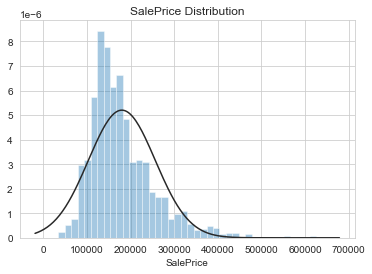

In [52]:
y = training_data['SalePrice']
plt.figure()
plt.title('SalePrice Distribution')
sns.distplot(y, kde=False, fit=stats.norm);

From the graph above, it shows that the price is left skewed. Skew data makes a model difficult to find a proper pattern in the data which is the reason why we have to make a skew data into normal or Gaussian one. The `log-transformation` does remove or reduce skewness

<AxesSubplot:title={'center':'SalePrice Distrribution'}, xlabel='SalePrice'>

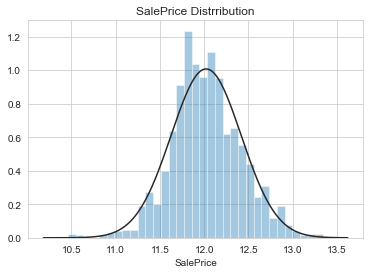

In [53]:
training_data['SalePrice'] = np.log1p(training_data['SalePrice'])
plt.figure()
plt.title('SalePrice Distrribution')
sns.distplot(training_data['SalePrice'], kde=False, fit=stats.norm)

Now, the above normal distribution looks better an the model can observe a better pattern from the data after applying the `log transformation`.

In [54]:
training_data.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,0,0,0,1,0,0,0,1,0
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,0,0,0,0,1,0,0,0,1,0
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,0,0,0,1,0,0,0,1,0
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,0,0,0,1,0,0,0,0,0
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,0,0,0,0,1,0,0,0,1,0


In [55]:
test_data.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1461.0,20.0,80.0,11622.0,5.0,6.0,1961.0,1961.0,0.0,468.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,1462.0,20.0,81.0,14267.0,6.0,6.0,1958.0,1958.0,108.0,923.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,1463.0,60.0,74.0,13830.0,5.0,5.0,1997.0,1998.0,0.0,791.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,1464.0,60.0,78.0,9978.0,6.0,6.0,1998.0,1998.0,20.0,602.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,1465.0,120.0,43.0,5005.0,8.0,5.0,1992.0,1992.0,0.0,263.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


## Splitting the Dataset into training and test data

In [56]:
X = training_data.drop('SalePrice', axis=1)
y = training_data['SalePrice']

In [57]:
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.3,random_state=1)

Training and Evaluating the data with different Regression model

### 1. Linear Regression Model

In [58]:
lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train)

LinearRegression()

In [59]:
lin_reg.score(X_test,y_test)

0.870659649015092

Predicting the test results

In [60]:
y_pred_1 = lin_reg.predict(X_test)

In [61]:
pd.DataFrame(lin_reg.coef_, X.columns, columns=['coefficient'])

,coefficient
Id,-0.000004
MSSubClass,-0.000548
LotFrontage,0.000226
LotArea,0.000003
OverallQual,0.041506
...,...
SaleCondition_AdjLand,-0.030485
SaleCondition_Alloca,0.048146
SaleCondition_Family,-0.022903
SaleCondition_Normal,0.058906


### Evaluation

In [62]:
lin_reg_mae = mean_absolute_error(y_test,y_pred_1)
lin_reg_mse = mean_squared_error(y_test,y_pred_1)
lin_reg_r2_score = r2_score(y_test,y_pred_1)
lin_reg_rmse = np.sqrt(lin_reg_mse)
print("The mean absolute error of the LinearRegression model is: ", lin_reg_mae)
print("The mean squared error of the LinearRegression model is: ", lin_reg_mse)
print("The r2 score value of the LinearRegression model is: ", lin_reg_r2_score)
print("The root mean squard error of the LogisticRegression model is: ", lin_reg_rmse)

The mean absolute error of the LinearRegression model is:  0.0961689877093256
The mean squared error of the LinearRegression model is:  0.02200252857056204
The r2 score value of the LinearRegression model is:  0.870659649015092
The root mean squard error of the LogisticRegression model is:  0.14833249330663204


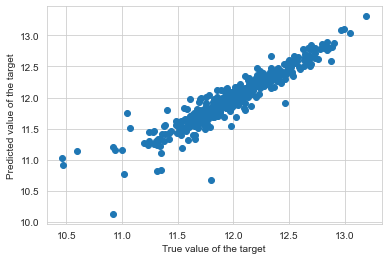

In [63]:
plt.scatter(x=y_test,y=y_pred_1)
plt.xlabel("True value of the target")
plt.ylabel("Predicted value of the target")
plt.show();

### 2. Random Forest Regressor Model

In [64]:
RF_reg = RandomForestRegressor(n_estimators=1000,max_features=0.6,random_state=1)
RF_reg.fit(X_train,y_train)

RandomForestRegressor(max_features=0.6, n_estimators=1000, random_state=1)

In [65]:
RF_reg.score(X_test,y_test)

0.8682646566396737

Visualizing the prediction

In [66]:
y_pred_2 = RF_reg.predict(X_test)

In [67]:
y_pred_2[:10]

array([11.88522454, 11.99583667, 11.71235577, 12.03247729, 11.97585697,
       11.88501101, 11.86072254, 11.83057914, 11.73920363, 12.36061584])

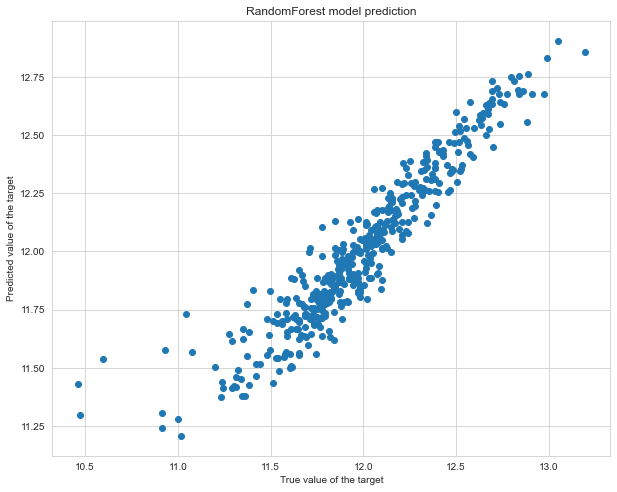

In [68]:
plt.figure(figsize=(10,8))
plt.scatter(x=y_test,y=y_pred_2)
plt.title("RandomForest model prediction")
plt.xlabel("True value of the target")
plt.ylabel("Predicted value of the target")
plt.show();

## Evaluation

In [69]:
RF_reg_mae = mean_absolute_error(y_test,y_pred_2)
RF_reg_mse = mean_squared_error(y_test,y_pred_2)
RF_reg_rmse = np.sqrt(RF_reg_mse)
RF_reg_r2_score = r2_score(y_test,y_pred_2)

print("The mean absolute error of the Random Forest Regressor is: ",RF_reg_mae)
print("The mean Squared error of the Random Forest Regressor is: ",RF_reg_mse)
print("The root mean squared error of the Random Forest Regressor is: ",RF_reg_rmse)
print("The r2 score value of the Random Forest Regressor is: ",RF_reg_r2_score)

The mean absolute error of the Random Forest Regressor is:  0.0991913387157375
The mean Squared error of the Random Forest Regressor is:  0.022409948898133036
The root mean squared error of the Random Forest Regressor is:  0.14969952871713738
The r2 score value of the Random Forest Regressor is:  0.8682646566396737


## 3. LassoCV model

In [70]:
Lasso_cv = LassoCV(alphas = [1e-3, 1e-2, 1e-1, 1, 0.0005, 0.0003, 0.005], random_state=1)
Lasso_cv.fit(X_train,y_train)

LassoCV(alphas=[0.001, 0.01, 0.1, 1, 0.0005, 0.0003, 0.005], random_state=1)

In [71]:
Lasso_cv.score(X_test,y_test)

0.9082779384667261

In [72]:
y_pred_3 = Lasso_cv.predict(X_test)
y_pred_3[:10]

array([11.89491168, 12.10068256, 11.81707639, 11.92831062, 11.93883115,
       11.83229628, 11.83389215, 11.62451747, 11.9261968 , 12.36345488])

No handles with labels found to put in legend.


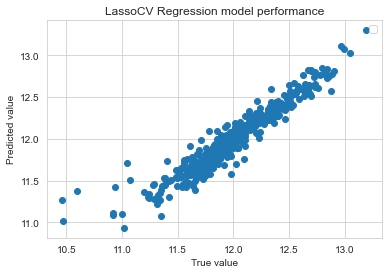

In [73]:
plt.figure()
plt.scatter(x=y_test,y=y_pred_3)
plt.title("LassoCV Regression model performance")
plt.xlabel("True value")
plt.ylabel("Predicted value")
plt.legend()
plt.show();

In [74]:
Lasso_cv_mae = mean_absolute_error(y_test,y_pred_3)
Lasso_cv_mse = mean_squared_error(y_test,y_pred_3)
Lasso_cv_rmse = np.sqrt(Lasso_cv_mse)
Lasso_cv_r2_score = r2_score(y_test,y_pred_3)

print("The mean absolute error of the LassoCV is: ",Lasso_cv_mae)
print("The mean squared error of the LassoCV is: ",Lasso_cv_mse)
print("The root mean squared error of the LassoCV is: ",Lasso_cv_rmse)
print("The r2 score value of the LassoCV is: ", Lasso_cv_r2_score)

The mean absolute error of the LassoCV is:  0.08401473220170264
The mean squared error of the LassoCV is:  0.015603152953189295
The root mean squared error of the LassoCV is:  0.124912581244602
The r2 score value of the LassoCV is:  0.9082779384667261


## 4. Ridge Regression model

In [75]:
ridge_rg = Ridge(random_state=1)
ridge_rg.fit(X_train,y_train)

Ridge(random_state=1)

In [76]:
ridge_rg.score(X_test,y_test)

0.9012355970044323

In [77]:
y_pred_4 = ridge_rg.predict(X_test)
y_pred_4[:10]

array([11.92636166, 12.1287197 , 11.81156455, 11.95009713, 11.92545672,
       11.80341744, 11.91630616, 11.55627008, 11.95859561, 12.36628106])

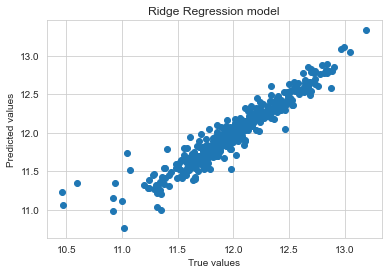

In [78]:
plt.figure()
plt.scatter(x=y_test,y=y_pred_4)
plt.title('Ridge Regression model')
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.show();

## Evaluation

In [79]:
ridge_rg_mae = mean_absolute_error(y_test,y_pred_4)
ridge_rg_mse = mean_squared_error(y_test,y_pred_4)
ridge_rg_rmse = np.sqrt(ridge_rg_mse)
ridge_rg_r2_score = r2_score(y_test,y_pred_4)

print("The mean absolute error of the Ridge regression model is: ",ridge_rg_mae)
print("The mean squared error of the Ridge regression model is: ",ridge_rg_mse)
print("The root mean squared error of the Ridge regression model is: ",ridge_rg_rmse)
print("The r2 score value of the Ridge regression model is: ",ridge_rg_r2_score)

The mean absolute error of the Ridge regression model is:  0.08819868586868011
The mean squared error of the Ridge regression model is:  0.016801149696261772
The root mean squared error of the Ridge regression model is:  0.1296192489418982
The r2 score value of the Ridge regression model is:  0.9012355970044323


In [80]:
xgb_model = xgb.XGBRegressor(learning_rate=0.01,n_estimators=3460,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:linear', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00006)
xgb_model.fit(X_train,y_train)

[04:43:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=3,
             min_child_weight=0, missing=nan, monotone_constraints='()',
             n_estimators=3460, n_jobs=4, nthread=-1, num_parallel_tree=1,
             objective='reg:linear', random_state=27, reg_alpha=6e-05,
             reg_lambda=1, scale_pos_weight=1, seed=27, subsample=0.7,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [81]:
xgb_model.score(X_test,y_test)

0.909025194130388

In [82]:
y_pred_5 = xgb_model.predict(X_test)
y_pred_5[:10]

array([11.789122 , 12.064996 , 11.79459  , 12.002391 , 11.94628  ,
       11.892399 , 11.832878 , 11.7272625, 11.811284 , 12.425789 ],
      dtype=float32)

In [83]:
xgb_model_mae = mean_absolute_error(y_test,y_pred_5)
xgb_model_mse = mean_squared_error(y_test,y_pred_5)
xgb_model_rmse = np.sqrt(xgb_model_mse)
xgb_model_r2_score = r2_score(y_test,y_pred_5)

print("The mean absolute error of the XGBRegressor model is: ",xgb_model_mae)
print("The mean squared error of the XGBRegressor model is: ",xgb_model_mse)
print("The root mean squared error of the XGBRegressor model is: ",xgb_model_rmse)
print("The r2 score value of the XGBRegressor model is: ",xgb_model_r2_score)

The mean absolute error of the XGBRegressor model is:  0.08004997859545608
The mean squared error of the XGBRegressor model is:  0.015476034741710549
The root mean squared error of the XGBRegressor model is:  0.12440271195480647
The r2 score value of the XGBRegressor model is:  0.909025194130388


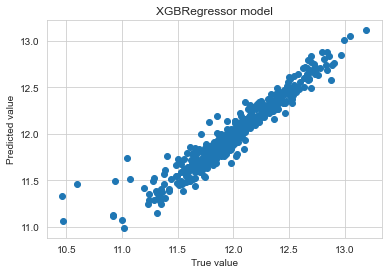

In [84]:
plt.figure()
plt.scatter(x=y_test,y=y_pred_5)
plt.title('XGBRegressor model')
plt.xlabel('True value')
plt.ylabel('Predicted value')
plt.show()

R^2 score of Linear Regression Model :  0.870659649015092
R^2 score of Random Forrest Regression Model :  0.8682646566396737
R^2 score of Lasso Regression Model :  0.9082779384667261
R^2 score of Ridge Regression Model:  0.9012355970044323
R^2 score of XGBoost Regression Model :  0.909025194130388


(0.6, 1.0)

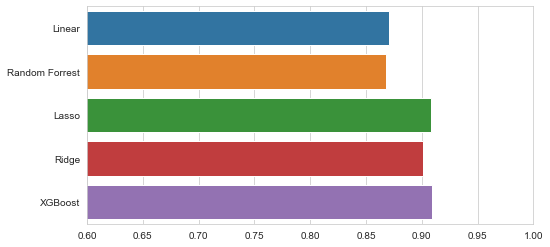

In [85]:
print("R^2 score of Linear Regression Model : ",lin_reg_r2_score)
print("R^2 score of Random Forrest Regression Model : ",RF_reg_r2_score)
print("R^2 score of Lasso Regression Model : ",Lasso_cv_r2_score)
print('R^2 score of Ridge Regression Model: ',ridge_rg_r2_score)
print("R^2 score of XGBoost Regression Model : ",xgb_model_r2_score)
models_score_r2=[lin_reg_r2_score,RF_reg_r2_score,Lasso_cv_r2_score,ridge_rg_r2_score,xgb_model_r2_score]
names_of_models=['Linear','Random Forrest','Lasso','Ridge','XGBoost']
sns.barplot(y=names_of_models,x=models_score_r2)
plt.gcf().set_size_inches(8,4)
plt.xlim([0.6,1.0])

In this comparison, Lasso and XGBoost has very close value of r2_score. However, the XGBoost is used for the prediction.

## Submission

In [86]:
test_data.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1461.0,20.0,80.0,11622.0,5.0,6.0,1961.0,1961.0,0.0,468.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,1462.0,20.0,81.0,14267.0,6.0,6.0,1958.0,1958.0,108.0,923.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,1463.0,60.0,74.0,13830.0,5.0,5.0,1997.0,1998.0,0.0,791.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,1464.0,60.0,78.0,9978.0,6.0,6.0,1998.0,1998.0,20.0,602.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,1465.0,120.0,43.0,5005.0,8.0,5.0,1992.0,1992.0,0.0,263.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [87]:
test_df.shape

(1459, 80)

In [88]:
final_pred = xgb_model.predict(test_data)

In [90]:
submission = pd.DataFrame({'id': test_data['Id'], 'SalePrice': final_pred}).head()
submission

,id,SalePrice
0,1461.0,11.807013
1,1462.0,11.940238
2,1463.0,12.141198
3,1464.0,12.188129
4,1465.0,12.152329


In [91]:
final_pred = final_pred[0:1459]

In [93]:
submission = pd.DataFrame({'Id': test_df['Id'], 'SalePrice': np.expm1(final_pred)})

In [94]:
submission

,Id,SalePrice
0,1461,134189.078125
1,1462,153312.171875
2,1463,187436.015625
3,1464,196442.359375
4,1465,189534.093750
...,...,...
1454,2915,86019.007812
1455,2916,91398.523438
1456,2917,168498.968750
1457,2918,134432.453125


In [95]:
submission.to_csv("submission.csv", index=False)